In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Dataset

In [5]:
file_path = "Heart_Disease_Prediction.csv" # Make sure to change this
df_LDA = pd.read_csv(file_path).drop(["index"], axis = 1)
target_variable = df_LDA['Heart Disease']
df_LDA = df_LDA.drop(['BP', 'Cholesterol', 'FBS over 120', 'EKG results','Heart Disease'], axis = 1)

n_col = len(df_LDA)
n_feat = len(df_LDA.columns)

X = df_LDA
y = target_variable

array = []
for x in range(len(y)):
    if(y[x] == "Absence"):
        array.append(0)
    else:
        array.append(1)
y = pd.DataFrame(data = array, columns=["Heart Disease"])
y=y['Heart Disease']
#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

# Hyperparameter Tuning

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.844 (0.061)


In [7]:
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(X, y)
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.844
Config: {'solver': 'svd'}


In [8]:
grid = dict()
grid['solver'] = ['lsqr', 'eigen']
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(X, y)
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.844
Config: {'solver': 'lsqr'}


# Hyperparameter Tuning Shrinkage

In [9]:
model = LinearDiscriminantAnalysis(solver='lsqr')
grid = dict()
grid['shrinkage'] = np.arange(0, 1, 0.01)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
lda_grid = GridSearchCV(model, grid, scoring='accuracy', cv=cv)
results = lda_grid.fit(X_train, y_train)
print(results.best_params_)
print(results.best_score_)

{'shrinkage': 0.0}
0.8555555555555556


In [10]:
print(X_train)

     Age  Sex  Chest pain type  Max HR  Exercise angina  ST depression  \
185   43    1                3     162                0            1.9   
66    51    1                4     186                1            0.0   
204   55    1                4     145                1            0.8   
250   54    1                4     113                0            1.4   
168   45    0                4     152                1            0.2   
..   ...  ...              ...     ...              ...            ...   
203   51    1                4     173                1            1.6   
255   71    0                2     162                0            0.4   
72    70    1                2     143                0            0.0   
235   62    0                4     145                0            6.2   
37    59    1                1     125                0            0.0   

     Slope of ST  Number of vessels fluro  Thallium  
185            1                        1         3  
66 

In [11]:
y_bias = []
y_var = []
for param in grid['shrinkage']:
    best_lda_model = LinearDiscriminantAnalysis(solver='lsqr')
    best_lda_model.fit(X_train, y_train)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        best_lda_model, X_train.values, y_train.values, X_test.values, y_test.values, 
        loss='0-1_loss')
    y_bias.append(avg_bias)
    y_var.append(avg_var)

In [12]:
array=[]
for x in grid['shrinkage']:
    array.append(x)

Text(0, 0.5, 'Bias - Variance')

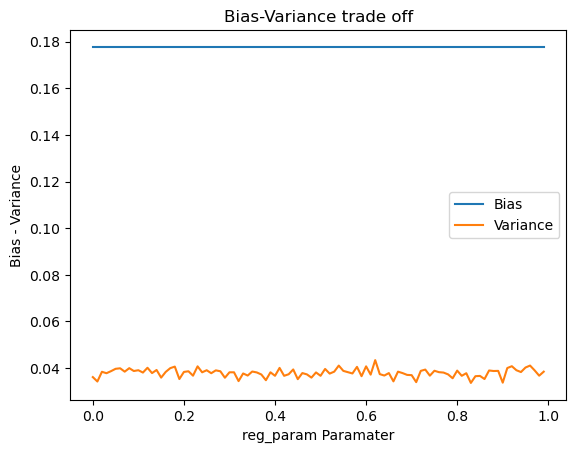

In [13]:
plt.plot(grid['shrinkage'], y_bias)
plt.plot(grid['shrinkage'], y_var)
plt.legend(['Bias','Variance'])
plt.title("Bias-Variance trade off")
plt.xlabel("reg_param Paramater")
plt.ylabel("Bias - Variance")

# Variance, Mean Square Error, and Bias

In [19]:
model = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage=0.0)
mse, bias, var = bias_variance_decomp(model, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=1)
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.195
Bias: 0.166
Variance: 0.029


# Confusion Matrix

In [15]:
y_pred=model.predict(X_test)
LDA_con_mat = confusion_matrix(y_test, y_pred)
print(LDA_con_mat)

[[42  3]
 [16 29]]


C:\Users\Felipe\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


# F-Score

In [16]:
target_names = ['class Presence', 'class Abscence']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

class Presence       0.72      0.93      0.82        45
class Abscence       0.91      0.64      0.75        45

      accuracy                           0.79        90
     macro avg       0.82      0.79      0.78        90
  weighted avg       0.82      0.79      0.78        90



# Bias Variance

In [20]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train.values, y_train.values, X_test.values, y_test.values, 
        loss='0-1_loss')
print("this is the average bias: ", avg_bias)
print("this is the average variance: ", avg_var)

this is the average bias:  0.17777777777777778
this is the average variance:  0.04094444444444444


# ROC Curve

The area under the curve is:  0.7888888888888889


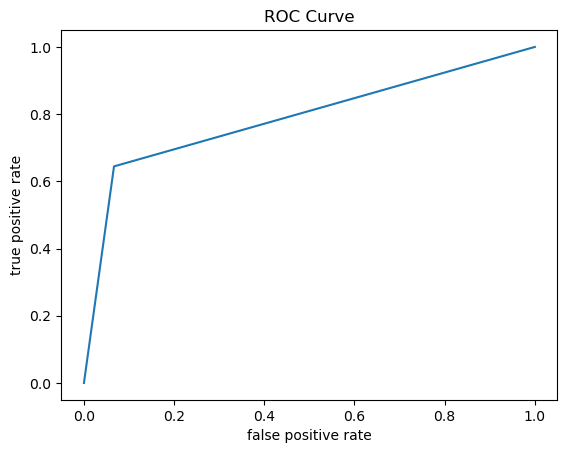

In [18]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
plt.plot(false_positive_rate, true_positive_rate)
plt.title("ROC Curve")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
area_under_curve = roc_auc_score(y_test, y_pred)
print("The area under the curve is: ", area_under_curve)

In [122]:
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print("cross validation score is: ", np.mean(scores))

cross validation score is:  0.8444444444444443


# Testing Accuracy of Model

In [140]:
row = [70, 1, 4, 109, 0, 2.4, 2, 3, 3]
model.fit(X_train.values, y_train.values)
test = model.predict(X_test.values)
number_match = 0
track = 0
for number in y_test:
    if(number == test[track]):
        number_match += 1
        track += 1
    else:
        track += 1
print(number_match/len(test))

0.8222222222222222
